### Angular Clustering in a Single Redshift Bin

In this notebook we consider Angular Clustering in a single redshift bin.

We use as a baseline scenario a redshift bin of size $\delta z = 0.2$: $\,\,\, z \in [0.4, 0.6]$.

Later we will relax this assumption and we will explore the difference between bin sizes.

###### ANGULAR POWER SPECTRA:

Using the Limber  and flat-sky approximations (valid for $\ell > 10$)  the angular power spectra of the projected field in a redshift bin $i$ can be written as: 

\begin{equation} 
C_\ell^{i} = \int_0^\infty dz \frac{H(z)}{c}\left(\frac{W^i(z)}{\chi(z)}\right)^2 P_{NL}\left(k=\frac{\ell+1/2}{\chi(z)}, z \right).
\end{equation}


###### Modeling the weighting kernel

If the overall normalized redshift distribution of a sample is $dn/dz$, the galaxy clustering weighting kernel in a redshift bin $i$ can be written as:

\begin{equation}
W^{i} = b(z)\frac{\frac{dn}{dz}F^{i}(z)}{\int_0^{\infty} \frac{dn}{dz'}F^i(z')dz'}
\end{equation}

where $b(z)$ the linear bias in the bin.

###### Assumptions

Here we will make a few simplyfing assumptions:

$\bullet$ First, we will assume that the overall redshift distribution is constant inside the bin: $dn/dz \sim$ const.
This is well justified for narrow bins.

$\bullet$ Second, we will assume that the bias is constant inside the bin: $b(z) \sim b^{i} = 1 + \bar{z}$.

$\bullet$ Furthermore we assume gaussian photo-z errors, described by one photo-z scatter and one photo-z bias parameter.

We leave free to very the cosmological parameters $\theta_c = [\Omega_{m}, \sigma_{8}]$, one galaxy bias parameter, $b_g$, and the the photo-z parameters ${\theta}_z = [\sigma_{z,0}, z_b]$.

We use as a statistic, the figure of merit between the two cosmological parameters FoM_{\theta}_c, but we may also consider the marginalized constraints on the individual cosmological parameters.

###### Goals / questions

We use the simple single-bin case as a starting, simple, case to studey in detail:

 - The trade-offs between redshift uncertainty and sample size.
 - How trade-offs depend on the uncertainties in these parameters ($\sigma(\sigma_z), \, \sigma(z_b)$)
 - Discuss about calibration requirements etc.
 - Discuss about bin size.
 
 We will discuss all the above in detail for the single bin case. Then, after having developed intuition, we will discuss some more particular cases for the more complicated, multiple-bin study.
 
 

In [1]:
# Import stuff
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
from scipy import interpolate 
from code.plot_utils import plot_pretty
from matplotlib import rcParams
rcParams['font.family'] = 'serif' 
%matplotlib inline
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Import the Fisher code (single bin)
from Ang_clust_SINGLE_BIN import Fish_single_bin as FSB

# Import function that calculates the Angular power spectrum in a bin
from Ang_clust_SINGLE_BIN import C_l_i as APS #this means angular power spectrum

# Import function that marginalizes over the the nuisance parameters
from Tools import marginalize as marg

# Import function that calculates the Angular power in a bin for a specific value of \ell
from Tools import C_l_specif as APS_specif

Just in case we need it, let's import CosmicFish

In [22]:
# Import CosmicFish now

import math
import sys
import os
import IPython

#=================================================================================

cosmicfish_pylib_path = '/Users/Dimitris/Desktop/Candidacy_all/Theory/CosmicFish/python'
sys.path.insert(0, os.path.normpath(cosmicfish_pylib_path))

#================================================================================
import cosmicfish_pylib.utilities            as fu
import cosmicfish_pylib.colors               as fc
import cosmicfish_pylib.fisher_matrix        as fm
import cosmicfish_pylib.fisher_derived       as fd
import cosmicfish_pylib.fisher_operations    as fo
import cosmicfish_pylib.fisher_plot_settings as fps
import cosmicfish_pylib.fisher_plot_analysis as fpa
import cosmicfish_pylib.fisher_plot          as fp

Let's summarize again the main points I want to adress in this notebook: 

- Trade-offs between sample size and photo-z uncertainty. 

In the single bin case I will assume the underlying redshift distribution is constant: $\frac{dn}{dz} \sim const$. This is approximately true for narrow bins. In that case, the constraints depend only on $N_g$ (sample size) and $\sigma_z$ (redshift uncertainty).

I want to: 

- Show trade-offs in that bin.

- Explain their origin (Signal to noise, Uncertainty in calibration)

- Explore dependence on bin size.

- Show that when bin size $\sim \sigma_z \to$ no more information

Fiducial values: $\sigma_{z} = \sigma_{z,0}(1 + z)$ and $z_b = 0.0$, $b_g = 1+ \bar{z}$.

### The origin of trade-offs 

In the first part, I want to present some plots that help us built some intuition about the origin of trade-offs/ how different factors (sample size, redshift uncertainty) compete. 

Discuss about perfect and imperfect knowledge of photo-zs.

I will define two samples in the redshift bin [0.4 - 0.6]:

- One with size $N_g = 1.1 \times 10^6$ galaxies and $\sigma_{z,0} = 0.014$. We call this "redMaGic - like" (RM) sample.
- One with size $N_g = 2.8 \times 10^7$ galaxies and $\sigma_{z,0} = 0.08$. We call this "flux limited-like" (FL) sample.

Inputs of the functions:

FSB(z_i, z_f, sig_z, z_bias, bias, f_sky, N_gal)

APS(z_i, z_f, sig_z, z_bias, bias, Omega_m_var, sig_8_var)

For future reference, error in one bin:


\begin{equation}
\delta C_\ell^i = \sqrt{\frac{2}{f_{sky}(2\ell+1)}}\left(C_\ell^i + \frac{1}{\bar{n}^i} \right)
\end{equation}

In [4]:
# Let's put here the limits and everything we are going to need for the calculations

z_i = 0.4
z_f = 0.6
z_m = 0.5*(z_i + z_f)
bias = 1.0 + z_m  #Common galaxy bias
z_bias = 0.0

sig_rm = 0.014 #Redshift error of the redMaGiC-like sample
sig_fl = 0.08 #Redshift error of the Flux limited-like sample
N_rm = 1.1e6 # Size of the redMaGiC-like sample
N_fl = 2.8e7 # Size of the flux-limited like sample
omega_m = 0.301  # Fiducial value of Omega_m
sig_8 = 0.798 # Fiducial value of sigma_8

f_sky = 4580.0/41253.0
ster = f_sky*(4.0*np.pi)

In [5]:
# A module to calculate l_max
import camb
from camb import model, initialpower

Omega_m = 0.301
sigma_8 = 0.798
h = 0.682
    
#Setting up cosmology - need to calculate chis
# Setting up cosmology
    
cosmo = camb.CAMBparams()
cosmo.set_cosmology(H0=68.2, ombh2=0.048*(h**2.0), omch2=(Omega_m - 0.048)*(h**2.0), mnu=0.06, omk=0, tau=0.06)
backres = camb.get_background(cosmo)

chi_mean = backres.comoving_radial_distance(z_m)   # comoving distance corresponding to the mean redshift of the bin
k_cutoff= 0.6*h #Cutoff scale in  Mpc^{-1}
l_max = int(round(chi_mean*k_cutoff))

print(l_max)

793


### Plots of $C_\ell$ and $\delta C_\ell$.

In [6]:
# Calculate ell and C_\ell for the RM and FL samples in that bin

ell, C_l_rm = APS(z_i, z_f, sig_rm, z_bias, bias, Omega_m, sig_8) #APS for the redMaGic sample in the bin
ell, C_l_fl = APS(z_i, z_f, sig_fl, z_bias, bias, Omega_m, sig_8) #APS for the flux limited sample in the bin

# Calculate also their errors, \delta C_\ell, using the above formula
prefact = np.sqrt(2.0/(f_sky*(2.0*ell + 1.0)))

delt_C_rm = prefact*(C_l_rm + (ster/N_rm))
delt_C_fl = prefact*(C_l_fl + (ster/N_fl))

A plot that I can make is the one that shows $C_\ell, \,\, \delta C_\ell$, and their ratio.

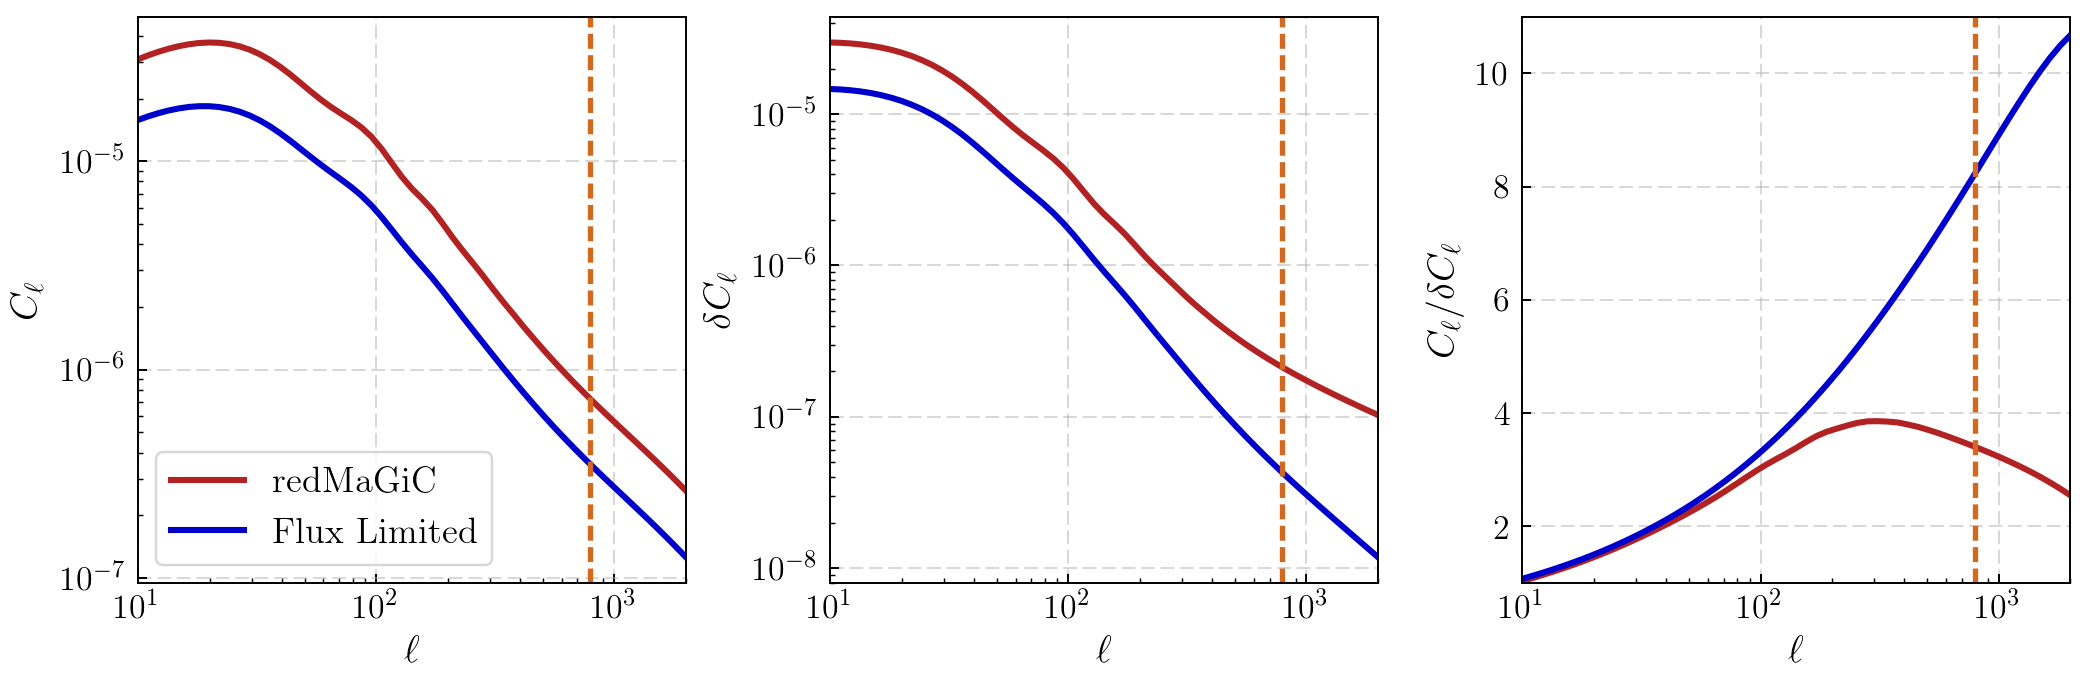

In [19]:
plot_pretty()

fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (12.0,4.0))

ax[0].plot(ell,C_l_rm, c='firebrick', linewidth=2.5, label='redMaGiC' )
ax[0].plot(ell,C_l_fl, c='mediumblue', linewidth=2.5, label='Flux Limited')
ax[0].set_xscale('log');ax[0].set_yscale('log')
ax[0].set_xlim(10.0,2000.0)
ax[0].set_xlabel(r'$\ell$',fontsize=16);ax[0].set_ylabel('$C_\ell$', fontsize=16)
ax[0].axes.tick_params(axis='both', labelsize=14)
ax[0].legend(frameon=True, loc='lower left', fontsize=15)
ax[0].grid(ls='--', alpha=0.5)
ax[0].axvline(x=l_max, color='chocolate', ls ='--', linewidth=2.2)

#===============================================================================================

ax[1].plot(ell, delt_C_rm, c='firebrick', linewidth=2.5)
ax[1].plot(ell,delt_C_fl, c='mediumblue', linewidth=2.5)
ax[1].set_xscale('log');ax[1].set_yscale('log')
ax[1].set_xlim(10.0,2000.0)#
ax[1].set_xlabel('$\ell$',fontsize=16);ax[1].set_ylabel('$\delta C_\ell$', fontsize=16)
ax[1].axes.tick_params(axis='both', labelsize=14)
ax[1].grid(ls='--', alpha=0.5)
ax[1].axvline(x=l_max, color='chocolate', ls='--', linewidth=2.2)
#=============================================================================

ax[2].plot(ell, C_l_rm/delt_C_rm, c='firebrick', linewidth=2.5)
ax[2].plot(ell, C_l_fl/delt_C_fl, c='mediumblue', linewidth=2.5)
ax[2].set_xscale('log')#;ax[1].set_yscale('log')
ax[2].set_xlim(10.0,2000.0),ax[2].set_ylim(1.0,11.0)
ax[2].set_xlabel('$\ell$',fontsize=16);ax[2].set_ylabel('$C_\ell/\delta C_\ell$', fontsize=16)
ax[2].axes.tick_params(axis='both', labelsize=14)
ax[2].grid(ls='--', alpha=0.5)
ax[2].axvline(x=l_max, color='chocolate', ls='--', linewidth= 2.2)

plt.tight_layout()
#plt.savefig('C_l_delt_l.pdf')
plt.show()

Or I can show just the last one:

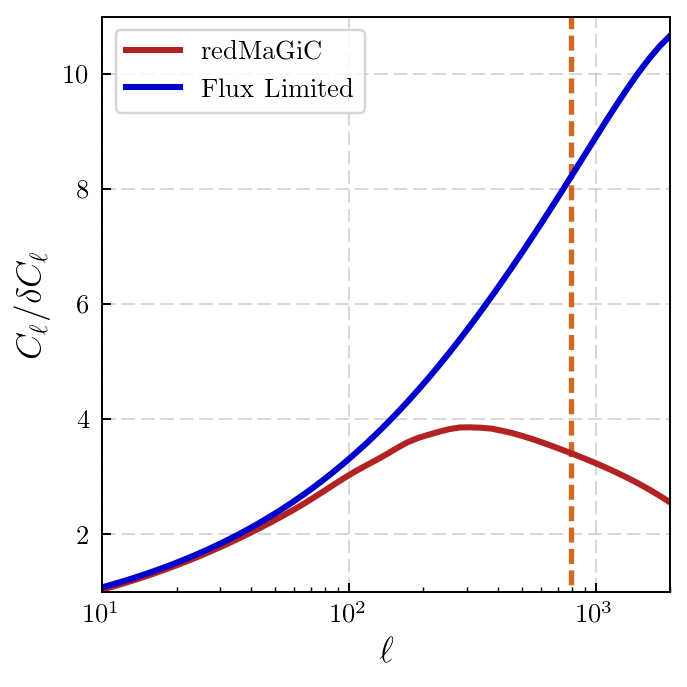

In [24]:
fig = plt.figure(figsize = (4.0,4.0))

plt.plot(ell,C_l_rm/delt_C_rm, c='firebrick', linewidth=2.5,label='redMaGiC')
plt.plot(ell,C_l_fl/delt_C_fl, c='mediumblue',linewidth=2.5,label='Flux Limited')
plt.xscale('log')#;plt.yscale('log')
plt.xlim(10.0,2000.0);plt.ylim(1.0,11)

plt.ylabel('$C_\ell/\delta C_\ell$',fontsize=15)
plt.xlabel('$\ell$',fontsize=15)
plt.grid(ls='--', alpha=0.5)
plt.legend(frameon=True, loc='upper left', fontsize=11)
plt.tick_params(axis='both', labelsize=11)
plt.vlines(l_max,0,11, color='chocolate', linestyle='--', linewidth= 2.2)

plt.tight_layout()
#plt.savefig('ratio.pdf')
plt.show()

Width of the bin. I will plot the ratio:  $\frac{C_\ell^{RM}}{C_\ell^{FL}}$, at $\ell = 200$ as a function of the bin size (always centered at $ z = 0.5$).

In [51]:
delta_z = np.linspace(0.05,0.40,50)
z_i = 0.5 - delta_z/2.0
z_f = 0.5 + delta_z/2.0
ell = 200

C_200_rm = np.zeros(50); C_200_fl = np.zeros(50)

for i in range(50):
    C_200_rm[i] = APS_specif(z_i[i], z_f[i], sig_rm, z_bias, bias, Omega_m, sig_8, ell) #RedMaGiC
    C_200_fl[i] = APS_specif(z_i[i], z_f[i], sig_fl, z_bias, bias, Omega_m, sig_8, ell) #Flux Limited

ratio_RM_FL = C_200_rm/C_200_fl

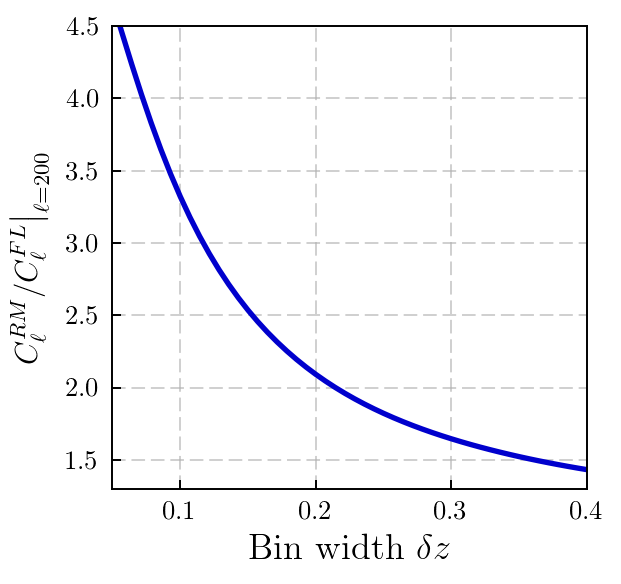

In [78]:
fig = plt.figure(figsize = (3.5,3.5))

plt.plot(delta_z, ratio_RM_FL, color='mediumblue', linewidth=2.2)
plt.grid(ls='--', alpha=0.6)

plt.tick_params(axis='both', labelsize=11)

plt.xlabel('Bin width $\delta z$', fontsize=15)
plt.ylabel(r'$\left. C_\ell^{RM}/C_\ell^{FL} \right|_{\ell = 200}$', fontsize =13)
plt.xlim(0.05,0.40);plt.ylim(1.3,4.5)


plt.show()

### Effect of uncertainty in the photo-z parameters

In the above we assumed a perferct knowledge of the photo-z parameters $\sigma_{z,0}$ and $z_b$. 
In practice we have to introduce uncertainties in these parameters, call them $\Delta \sigma_{z}$ and $\Delta z_b$. 

The key challenge to use of photo-z's in cosmological inference is the validation of the resulting redshift distribution, in other words the assignment of meaningful error distributions to the redshift errors.

A very simple model for the uncertainties is the following: If the calibration (spectroscopic) sample has size $N_{spec}$, the errors in the photo-z parameters are:

\begin{equation}
\Delta z_{bias} = \frac{\sigma_z}{\sqrt{N_{spec}}}
\end{equation}

and 

\begin{equation}
\Delta \sigma_z = \frac{\sigma_z}{\sqrt{N_{spec}/2}}
\end{equation}

So, here we want to see how uncertainties in the photo-z parameters translate into uncertainties in cosmology.
